In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse

df_integrated = pd.read_csv("run1/alldf_integrated.csv")
print(" File read done")

 File read done


In [2]:
#pbdf.shape[1]
# Get the name of the 3rd column (index 2, since indexing starts at 0)
third_column_name = df_integrated.columns[2]
print(third_column_name)


Timepoint


Explained variance by PCs: [0.23705257 0.12987514 0.09233882 0.07805261 0.06729548]


C:\Miniforge-all\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


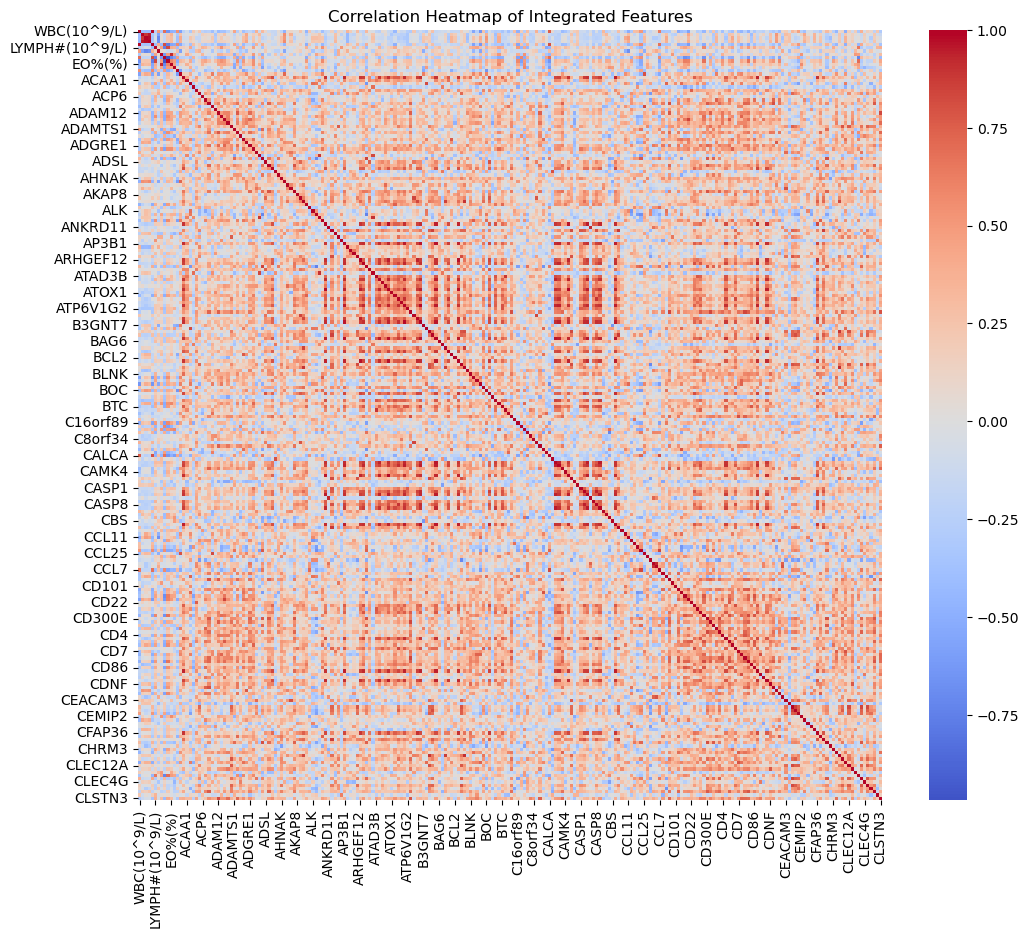

  PatientID  Timepoint  WBC(10^9/L)  RBC(10^12/L)  HGB(g/L)  HCT(L/L)  \
0  RB01_004          0    -0.881480     -0.021654  0.406230  0.241805   
1  RB01_004          1     1.113980     -1.000319 -0.516946 -0.498722   
2  RB01_004          2    -0.835990     -0.036482 -0.004070  0.188910   
3  RB01_005          0    -0.566088      0.245255  0.457518  0.277068   
4  RB01_005          1    -0.029315     -0.822380 -0.465658 -0.780828   

   NEUT#(10^9/L)  LYMPH#(10^9/L)  MONO#(10^9/L)  EO#(10^9/L)  ...    CLEC6A  \
0      -0.853457        0.189369      -0.772662     0.037803  ... -0.460303   
1       1.203108       -0.234875      -0.546517    -0.964965  ...  0.297744   
2      -0.859283        0.330784      -0.885735     0.727206  ...  0.873613   
3      -0.690330        0.652180       0.188454    -0.463581  ... -1.233982   
4       0.291344       -1.301912      -0.150763    -0.902292  ... -1.255403   

     CLEC7A    CLSTN2    CLSTN3        PC1       PC2       PC3       PC4  \
0  1.13969

In [7]:
#  it should run seperately , dnt run after anything
df_integrated = df_integrated.loc[:, ~df_integrated.columns.str.contains('^Unnamed')]
df_integrated = df_integrated.reset_index(drop=True)
# 1️⃣ Prepare numeric matrix
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]
X = df_integrated[numeric_cols].values

# 2️⃣ Optional: Standardize again (late integration scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results back to dataframe
for i in range(X_pca.shape[1]):
    df_integrated[f'PC{i+1}'] = X_pca[:,i]

print("Explained variance by PCs:", pca.explained_variance_ratio_)

# 4️⃣ K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_integrated['cluster'] = kmeans.fit_predict(X_scaled)

# 5️⃣ Correlation heatmap
corr_matrix = pd.DataFrame(X_scaled, columns=numeric_cols).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Integrated Features')
plt.show()

# 6️⃣ Show final integrated dataframe head with cluster and PCA
print(df_integrated.head())


C:\Users\mondalsy\AppData\Local\Temp\ipykernel_19720\3832252806.py:31: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(1 - corr_df.abs(), method='average')



Feature clusters:
      Marker  Cluster
52      AKT2        1
103      BCR        2
222     CHUK        3
97     BANK1        4
51    AKT1S1        5
..       ...      ...
35    ADGRE1      232
166     CCL8      233
86    ATRAID      234
192    CD79B      235
181  CD300LB      236

[236 rows x 2 columns]


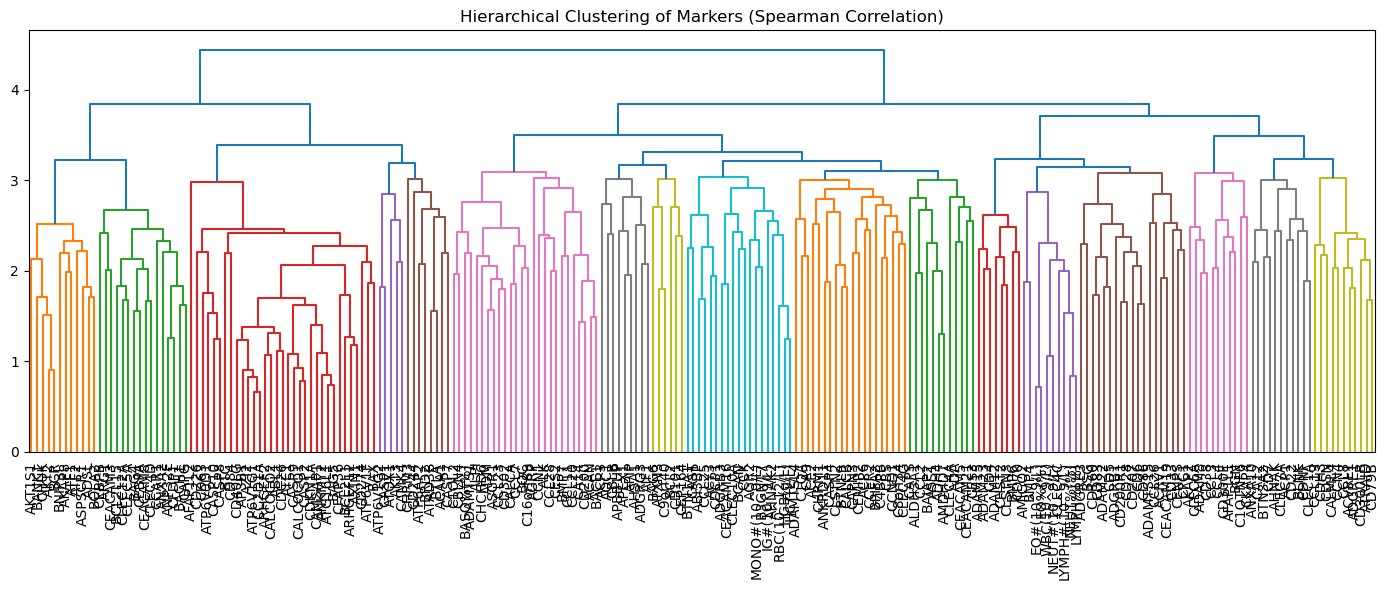

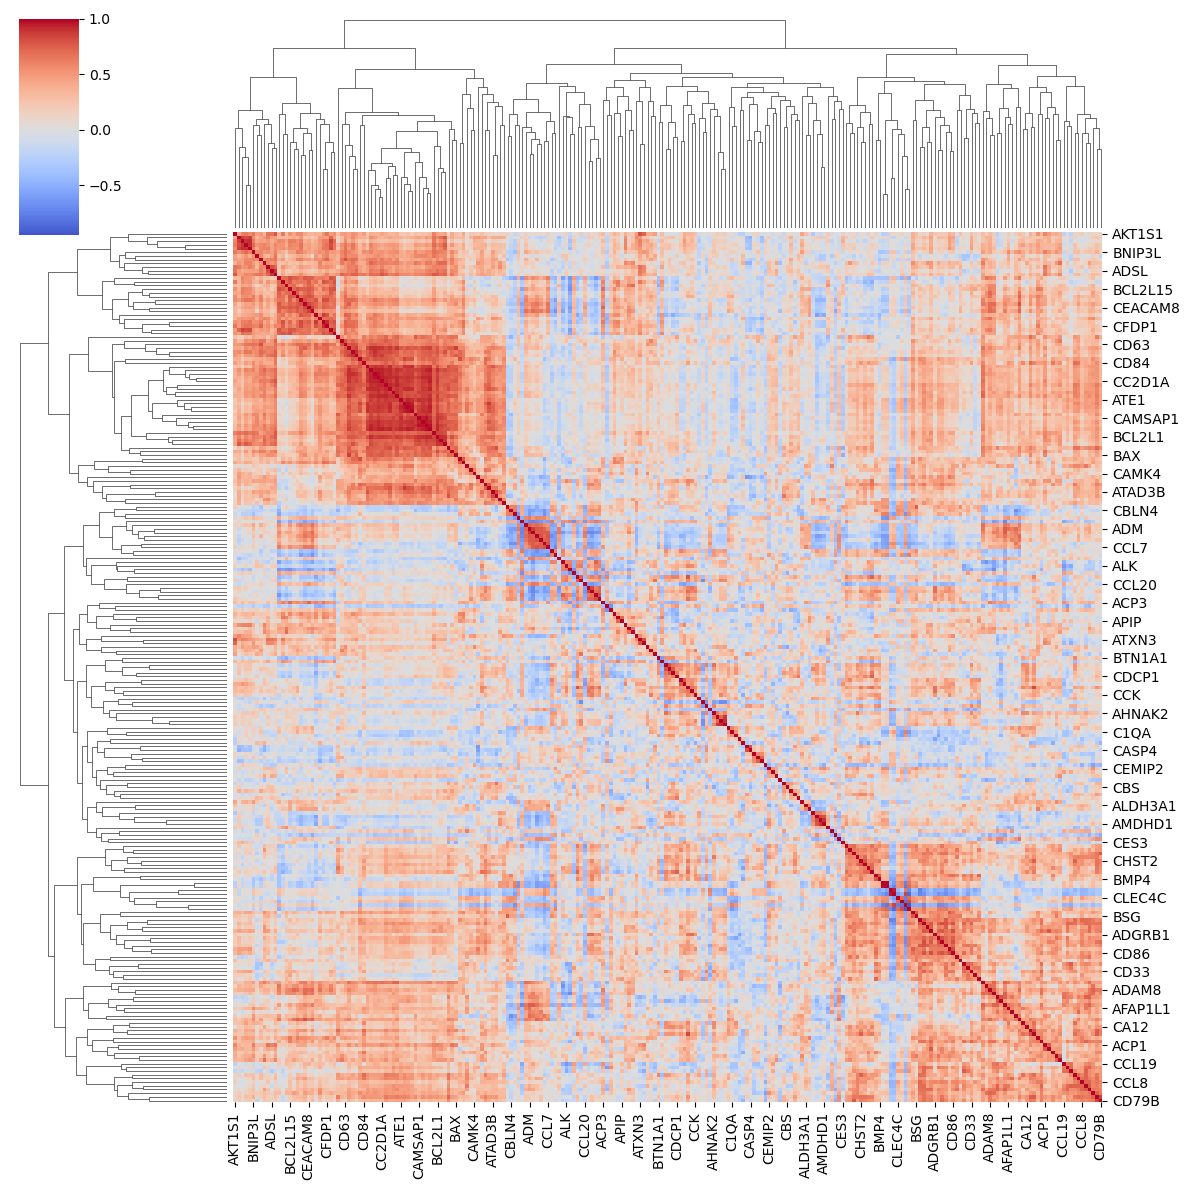


Strongly correlated markers (|r| ≥ 0.7):
             Marker_1   Marker_2  Spearman_r
1626      EO#(10^9/L)     EO%(%)    0.979397
16258        ATP6V1G1       AZI2    0.967980
15540         ATG16L1    CAMSAP1    0.965025
15498         ATG16L1       BAG5    0.963547
22387        CALCOCO1      CASP9    0.963547
...               ...        ...         ...
2071         NEUT%(%)     CLEC4C   -0.748368
1853         NEUT%(%)     EO%(%)   -0.783627
1167   LYMPH#(10^9/L)   NEUT%(%)   -0.814094
938     NEUT#(10^9/L)  LYMPH%(%)   -0.850351
1852         NEUT%(%)  LYMPH%(%)   -0.947770

[656 rows x 3 columns]


In [8]:
# ================================
# Hierarchical clustering & marker correlation
# ================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import spearmanr

# --------------------------------
# 1️⃣ Prepare numeric matrix again (standalone)
# --------------------------------
numeric_cols = [col for col in df_integrated.columns 
                if col not in ['PatientID', 'Timepoint', 'cluster'] 
                and not col.startswith('PC')]

X = df_integrated[numeric_cols]

# --------------------------------
# 2️⃣ Correlation matrix (Spearman – better for biomarkers)
# --------------------------------
corr_matrix, pvals = spearmanr(X)
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

# --------------------------------
# 3️⃣ Hierarchical clustering on features
# --------------------------------
linkage_matrix = linkage(1 - corr_df.abs(), method='average')

# --------------------------------
# 4️⃣ Cluster features (markers)
# --------------------------------
feature_clusters = fcluster(linkage_matrix, t=0.3, criterion='distance')

feature_cluster_df = pd.DataFrame({
    'Marker': numeric_cols,
    'Cluster': feature_clusters
}).sort_values('Cluster')

print("\nFeature clusters:")
print(feature_cluster_df)

# --------------------------------
# 5️⃣ Dendrogram
# --------------------------------
plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    labels=numeric_cols,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title('Hierarchical Clustering of Markers (Spearman Correlation)')
plt.tight_layout()
plt.show()

# --------------------------------
# 6️⃣ Correlation heatmap WITH hierarchical ordering
# --------------------------------
sns.clustermap(
    corr_df,
    row_linkage=linkage_matrix,
    col_linkage=linkage_matrix,
    cmap='coolwarm',
    center=0,
    figsize=(12, 12)
)
plt.show()

# --------------------------------
# 7️⃣ Identify strongly correlated marker pairs
# --------------------------------
corr_threshold = 0.7

strong_corr = (
    corr_df
    .where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

strong_corr.columns = ['Marker_1', 'Marker_2', 'Spearman_r']

strong_corr = strong_corr.loc[strong_corr['Spearman_r'].abs() >= corr_threshold]

print("\nStrongly correlated markers (|r| ≥ 0.7):")
print(strong_corr.sort_values(by='Spearman_r', ascending=False))


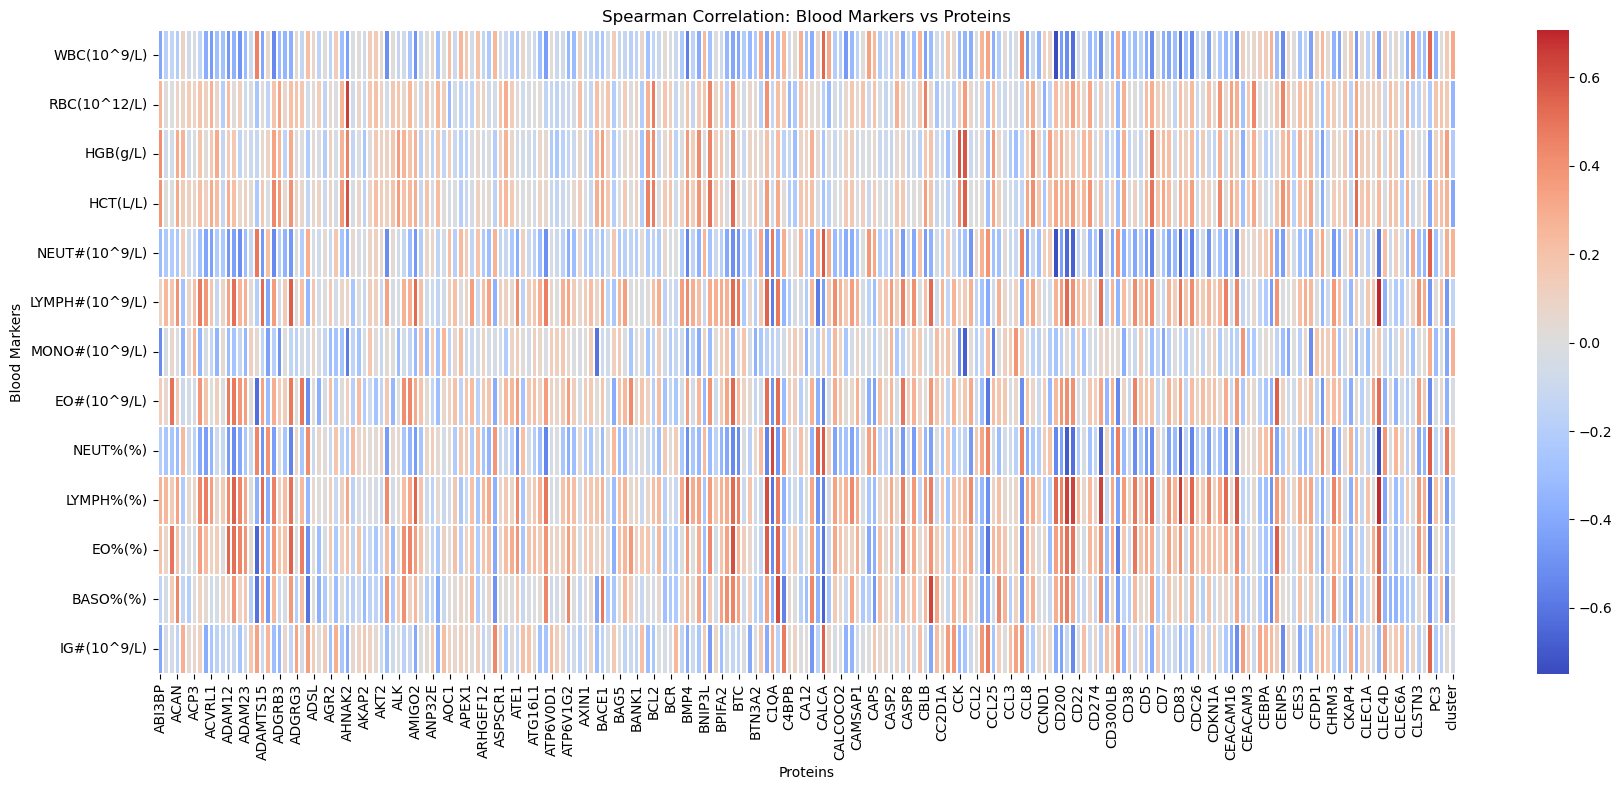


Significant Blood–Protein correlations:
        Blood_Marker   Protein  Spearman_r   p_value
1360  LYMPH#(10^9/L)    CLEC4C    0.705839  0.000019
2276       LYMPH%(%)    CLEC4C    0.698362  0.000025
2241       LYMPH%(%)      CD83    0.650819  0.000132
262     RBC(10^12/L)    AHNAK2    0.647696  0.000146
2221       LYMPH%(%)   CD200R1    0.644168  0.000163
2222       LYMPH%(%)     CD207    0.640966  0.000180
2227       LYMPH%(%)      CD28    0.632837  0.000230
2655        BASO%(%)     CBLN4    0.629216  0.000256
1940        NEUT%(%)      C1QA    0.620027  0.000334
2628        BASO%(%)     C1QL2    0.609908  0.000444
2168       LYMPH%(%)  C16orf89    0.605247  0.000504
2391          EO%(%)       BSG    0.603420  0.000530
2169       LYMPH%(%)      C1QA   -0.605493  0.000501
1451   MONO#(10^9/L)    B3GNT7   -0.607271  0.000477
2545        BASO%(%)       ADM   -0.608918  0.000456
2536        BASO%(%)   ADAMTS1   -0.614116  0.000395
1993        NEUT%(%)     CD207   -0.620766  0.000327
2285 

In [9]:
# ============================================
# Blood markers vs Protein correlation
# ============================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --------------------------------------------
# 1️⃣ Define feature groups
# --------------------------------------------
blood_features = df_integrated.columns[2:15]    # Blood markers
protein_features = df_integrated.columns[15:]  # Proteins

# --------------------------------------------
# 2️⃣ Compute Spearman correlation matrix
# --------------------------------------------
corr_matrix = pd.DataFrame(
    index=blood_features,
    columns=protein_features,
    dtype=float
)

pval_matrix = corr_matrix.copy()

for blood in blood_features:
    for protein in protein_features:
        r, p = spearmanr(
            df_integrated[blood],
            df_integrated[protein],
            nan_policy='omit'
        )
        corr_matrix.loc[blood, protein] = r
        pval_matrix.loc[blood, protein] = p

# --------------------------------------------
# 3️⃣ Heatmap: Blood vs Protein correlation
# --------------------------------------------
plt.figure(figsize=(18, 8))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.3
)
plt.title('Spearman Correlation: Blood Markers vs Proteins')
plt.xlabel('Proteins')
plt.ylabel('Blood Markers')
plt.tight_layout()
plt.show()

# --------------------------------------------
# 4️⃣ Extract significant correlations
# --------------------------------------------
corr_threshold = 0.6
pval_threshold = 0.05

significant_corr = (
    corr_matrix
    .stack()
    .reset_index()
)

significant_corr.columns = ['Blood_Marker', 'Protein', 'Spearman_r']

significant_corr['p_value'] = pval_matrix.stack().values

significant_corr = significant_corr[
    (significant_corr['Spearman_r'].abs() >= corr_threshold) &
    (significant_corr['p_value'] < pval_threshold)
]

print("\nSignificant Blood–Protein correlations:")
print(significant_corr.sort_values(by='Spearman_r', ascending=False))


In [ ]:
# significant features

Number of significant features: 66
Significant features: ['WBC(10^9/L)', 'NEUT#(10^9/L)', 'LYMPH#(10^9/L)', 'EO#(10^9/L)', 'NEUT%(%)', 'LYMPH%(%)', 'EO%(%)', 'IG#(10^9/L)', 'ABI3BP', 'ACAN', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAMTS15', 'ADGRB1', 'ADGRE1', 'ADGRE3', 'ADM', 'AHNAK2', 'ALPI', 'AMIGO2', 'APBB1IP', 'ASGR1', 'ATAD3B', 'ATP6AP2', 'ATRAID', 'BACE1', 'BMP4', 'BMP7', 'BOC', 'BSG', 'C16orf89', 'C1QTNF6', 'C8orf34', 'CA12', 'CA14', 'CALCA', 'CAPN3', 'CCL20', 'CCL23', 'CCL25', 'CCL7', 'CCN1', 'CCN4', 'CD200', 'CD207', 'CD244', 'CD28', 'CD300LB', 'CD302', 'CD4', 'CD6', 'CD70', 'CD83', 'CDCP1', 'CEACAM8', 'CEBPA', 'CEBPB', 'CEMIP2', 'CHCHD6', 'CKAP4', 'CLEC10A', 'CLEC4C', 'CLEC4D', 'CLSTN3']


<Figure size 1200x800 with 0 Axes>

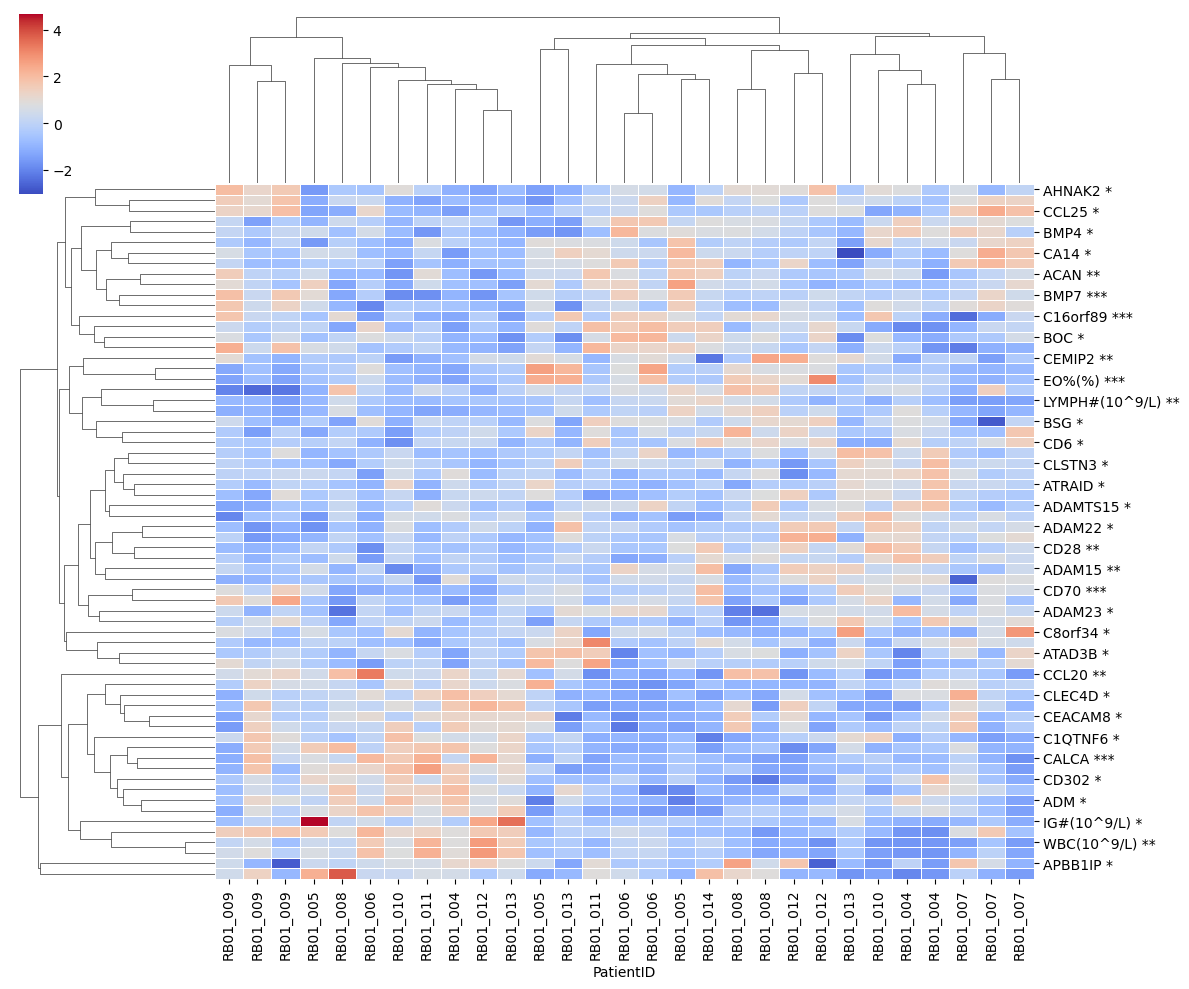

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1️⃣ Clean dataframe
# ---------------------------
# Drop unnamed index columns
df_integrated = df_integrated.loc[:, ~df_integrated.columns.str.contains('^Unnamed')]
df_integrated = df_integrated.reset_index(drop=True)

# Identify numeric columns
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]

# ---------------------------
# 2️⃣ Compute ANOVA p-values
# ---------------------------
p_values = {}
timepoints = df_integrated['Timepoint'].unique()
for col in numeric_cols:
    groups = [df_integrated[df_integrated['Timepoint']==tp][col].values for tp in timepoints]
    f_stat, p_val = f_oneway(*groups)
    p_values[col] = p_val

p_values = pd.Series(p_values)

# Function to convert p-value to stars
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

sig_stars = p_values.apply(significance_stars)

# ---------------------------
# 3️⃣ Select significant features
# ---------------------------
sig_features = p_values[p_values < 0.05].index.tolist()
print(f"Number of significant features: {len(sig_features)}")
print("Significant features:", sig_features)

# ---------------------------
# 4️⃣ Create subset with significant features
# ---------------------------
sig_data = df_integrated[['PatientID'] + sig_features]

# Add significance stars to feature names
sig_labels = [f"{f} {sig_stars[f]}" for f in sig_features]

# Create features x samples matrix
combined_data_scaled = sig_data[sig_features].T  # features x samples
combined_data_scaled.columns = sig_data['PatientID']  # samples as columns
combined_data_scaled.index = sig_labels

# Optional: scale features for better heatmap visualization
scaler = StandardScaler()
combined_data_scaled.loc[:, :] = scaler.fit_transform(combined_data_scaled)

# ---------------------------
# 5️⃣ Plot clustered heatmap
# ---------------------------
plt.figure(figsize=(12, 8))
clustermap = sns.clustermap(
    combined_data_scaled,
    cmap='coolwarm',
    figsize=(12, 10),
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    cbar_pos=(0.02, 0.8, 0.02, 0.18)
)

plt.show()


<Figure size 1200x800 with 0 Axes>

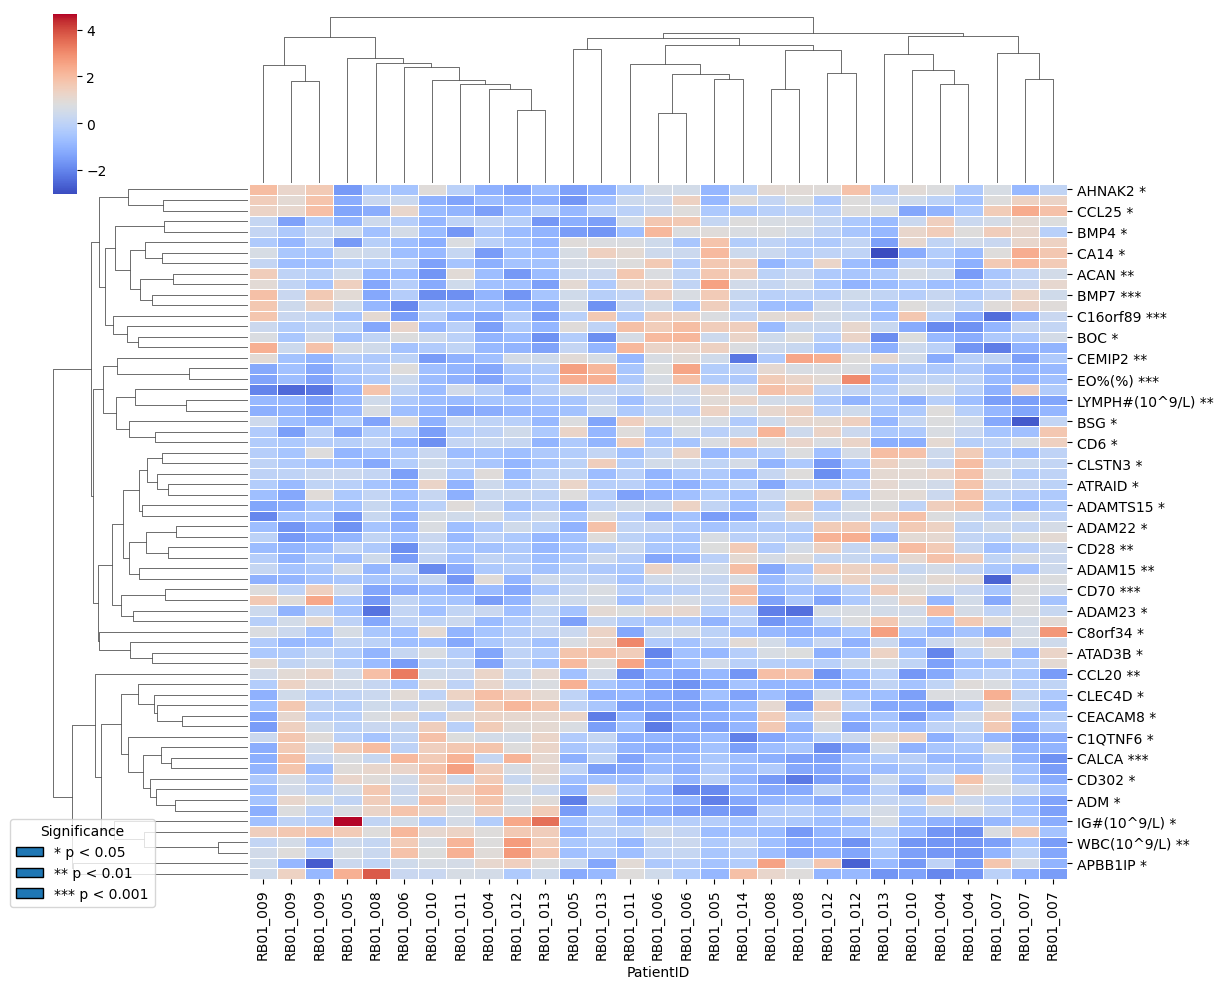

In [25]:
import matplotlib.patches as mpatches

# ---------------------------
# 5️⃣ Plot clustered heatmap
# ---------------------------
plt.figure(figsize=(12, 8))
clustermap = sns.clustermap(
    combined_data_scaled,
    cmap='coolwarm',
    figsize=(12, 10),
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    cbar_pos=(0.02, 0.8, 0.02, 0.18)
)

# Create legend for significance stars
legend_elements = [
    mpatches.Patch(edgecolor='black', label='* p < 0.05'),
    mpatches.Patch(edgecolor='black', label='** p < 0.01'),
    mpatches.Patch(edgecolor='black', label='*** p < 0.001')
]

# Add legend on left-bottom side
clustermap.ax_heatmap.legend(
    handles=legend_elements,
    title='Significance',
    loc='lower left',           # left-bottom
    bbox_to_anchor=(-0.3, -0.05)  # slightly outside the heatmap
)

plt.show()


In [28]:
# Assuming p_values is a pandas Series with feature names as index
sig_001 = p_values[p_values < 0.001].index.tolist()
sig_01  = p_values[(p_values >= 0.001) & (p_values < 0.01)].index.tolist()
sig_05  = p_values[(p_values >= 0.01) & (p_values < 0.05)].index.tolist()

# Number of features in each category
print("Number of features with p < 0.001 (***):", len(sig_001))
print("Features:", sig_001, "\n")

print("Number of features with 0.001 <= p < 0.01 (**):", len(sig_01))
print("Features:", sig_01, "\n")

print("Number of features with 0.01 <= p < 0.05 (*):", len(sig_05))
print("Features:", sig_05)


Number of features with p < 0.001 (***): 12
Features: ['NEUT#(10^9/L)', 'NEUT%(%)', 'LYMPH%(%)', 'EO%(%)', 'ADAM12', 'ASGR1', 'BMP7', 'C16orf89', 'CALCA', 'CCL23', 'CCL7', 'CD70'] 

Number of features with 0.001 <= p < 0.01 (**): 20
Features: ['WBC(10^9/L)', 'LYMPH#(10^9/L)', 'EO#(10^9/L)', 'ABI3BP', 'ACAN', 'ADAM15', 'ADGRB1', 'ADGRE3', 'ALPI', 'AMIGO2', 'CCL20', 'CD200', 'CD207', 'CD244', 'CD28', 'CD300LB', 'CD4', 'CDCP1', 'CEBPB', 'CEMIP2'] 

Number of features with 0.01 <= p < 0.05 (*): 34
Features: ['IG#(10^9/L)', 'ADAM22', 'ADAM23', 'ADAMTS15', 'ADGRE1', 'ADM', 'AHNAK2', 'APBB1IP', 'ATAD3B', 'ATP6AP2', 'ATRAID', 'BACE1', 'BMP4', 'BOC', 'BSG', 'C1QTNF6', 'C8orf34', 'CA12', 'CA14', 'CAPN3', 'CCL25', 'CCN1', 'CCN4', 'CD302', 'CD6', 'CD83', 'CEACAM8', 'CEBPA', 'CHCHD6', 'CKAP4', 'CLEC10A', 'CLEC4C', 'CLEC4D', 'CLSTN3']


In [27]:
len(sig_features)

66

In [ ]:
# Correlation analysis: which proteins correlate with blood markers.

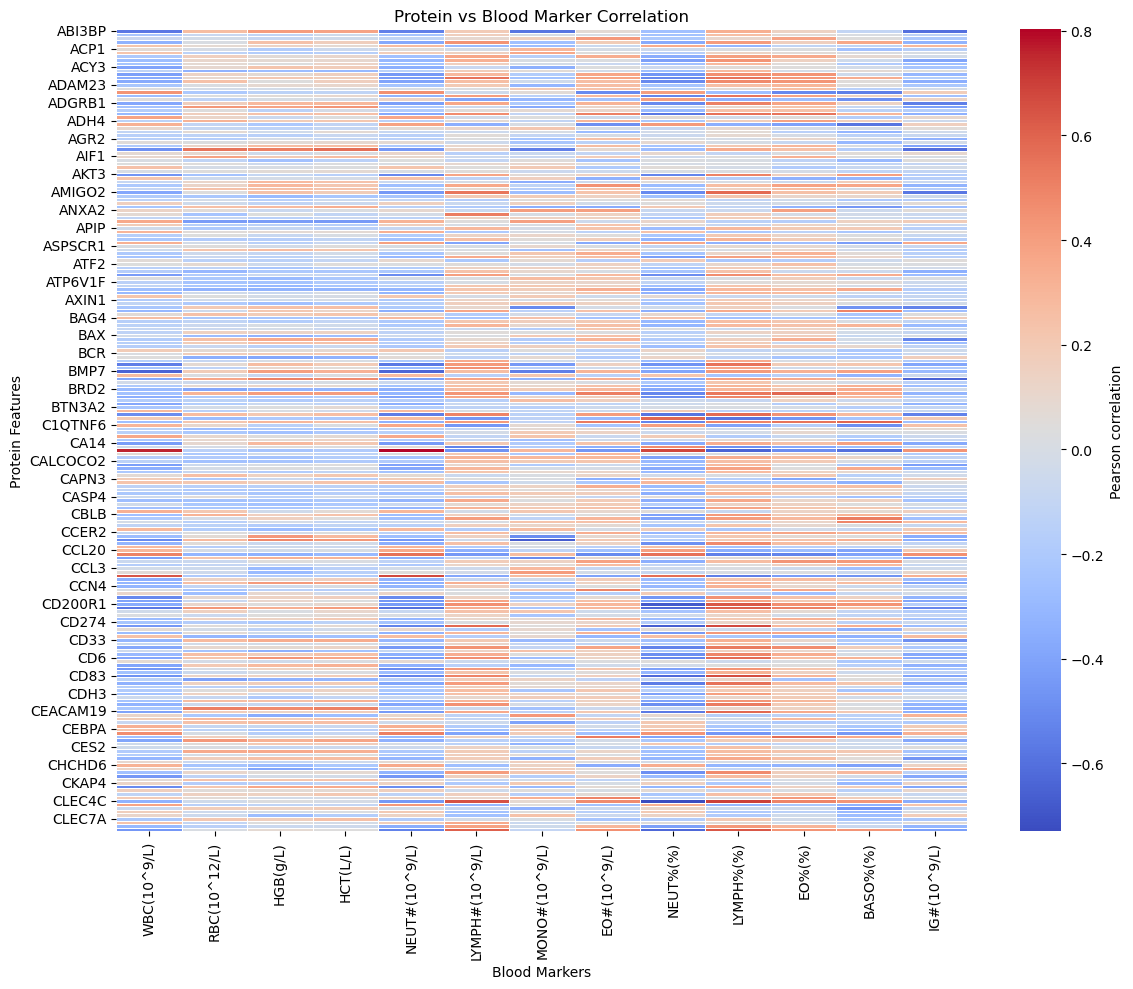

In [38]:
# ---------------------------
# 1️⃣ Define feature groups
# PatientID, Timepoint are first two columns
blood_features = df_integrated.columns[2:15]   # columns 2 to 14
protein_features = df_integrated.columns[15:]  # columns 15 to end
# ---------------------------
# 2️⃣ Subset data
# ---------------------------
# Subset numeric data
blood_data = df_integrated[blood_features].apply(pd.to_numeric, errors='coerce')
protein_data = df_integrated[protein_features].apply(pd.to_numeric, errors='coerce')

# Compute protein x blood correlation matrix
corr_prot_blood = pd.DataFrame(
    {b: protein_data.corrwith(blood_data[b]) for b in blood_data.columns},
    index=protein_data.columns
)

# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_prot_blood,
    cmap='coolwarm',
    annot=False,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Pearson correlation'}
)
plt.title("Protein vs Blood Marker Correlation")
plt.xlabel("Blood Markers")
plt.ylabel("Protein Features")
plt.tight_layout()
plt.show()



In [ ]:
#Clustering: see if samples naturally separate based on proteomics/blood markers.
K-means, hierarchical clustering.
Heatmaps with significant features.

Significant features: ['WBC(10^9/L)', 'NEUT#(10^9/L)', 'LYMPH#(10^9/L)', 'EO#(10^9/L)', 'NEUT%(%)', 'LYMPH%(%)', 'EO%(%)', 'IG#(10^9/L)', 'ABI3BP', 'ACAN', 'ADAM12', 'ADAM15', 'ADAM22', 'ADAM23', 'ADAMTS15', 'ADGRB1', 'ADGRE1', 'ADGRE3', 'ADM', 'AHNAK2', 'ALPI', 'AMIGO2', 'APBB1IP', 'ASGR1', 'ATAD3B', 'ATP6AP2', 'ATRAID', 'BACE1', 'BMP4', 'BMP7', 'BOC', 'BSG', 'C16orf89', 'C1QTNF6', 'C8orf34', 'CA12', 'CA14', 'CALCA', 'CAPN3', 'CCL20', 'CCL23', 'CCL25', 'CCL7', 'CCN1', 'CCN4', 'CD200', 'CD207', 'CD244', 'CD28', 'CD300LB', 'CD302', 'CD4', 'CD6', 'CD70', 'CD83', 'CDCP1', 'CEACAM8', 'CEBPA', 'CEBPB', 'CEMIP2', 'CHCHD6', 'CKAP4', 'CLEC10A', 'CLEC4C', 'CLEC4D', 'CLSTN3']


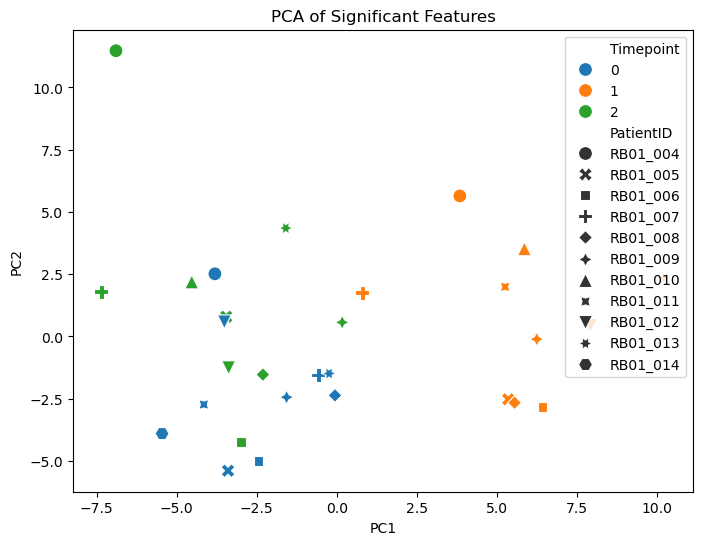

C:\Miniforge-all\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


K-means cluster assignment per sample:
    PatientID  KMeans_cluster
0   RB01_004               1
1   RB01_004               0
2   RB01_004               1
3   RB01_005               2
4   RB01_005               0
5   RB01_005               1
6   RB01_006               2
7   RB01_006               0
8   RB01_006               2
9   RB01_007               2
10  RB01_007               0
11  RB01_007               1
12  RB01_008               2
13  RB01_008               0
14  RB01_008               2
15  RB01_009               2
16  RB01_009               0
17  RB01_009               0
18  RB01_010               0
19  RB01_010               1
20  RB01_011               2
21  RB01_011               0
22  RB01_012               1
23  RB01_012               0
24  RB01_012               1
25  RB01_013               2
26  RB01_013               0
27  RB01_013               1
28  RB01_014               2


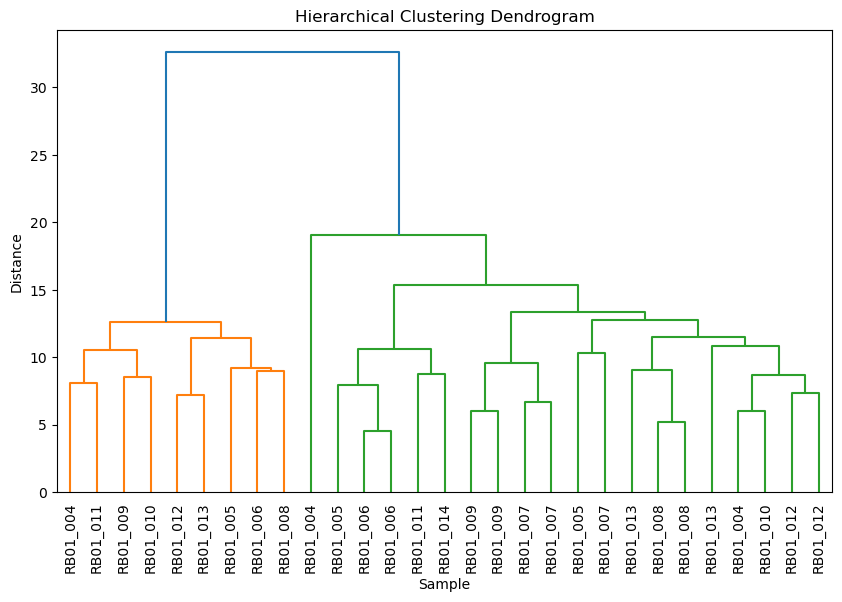

<Figure size 1200x800 with 0 Axes>

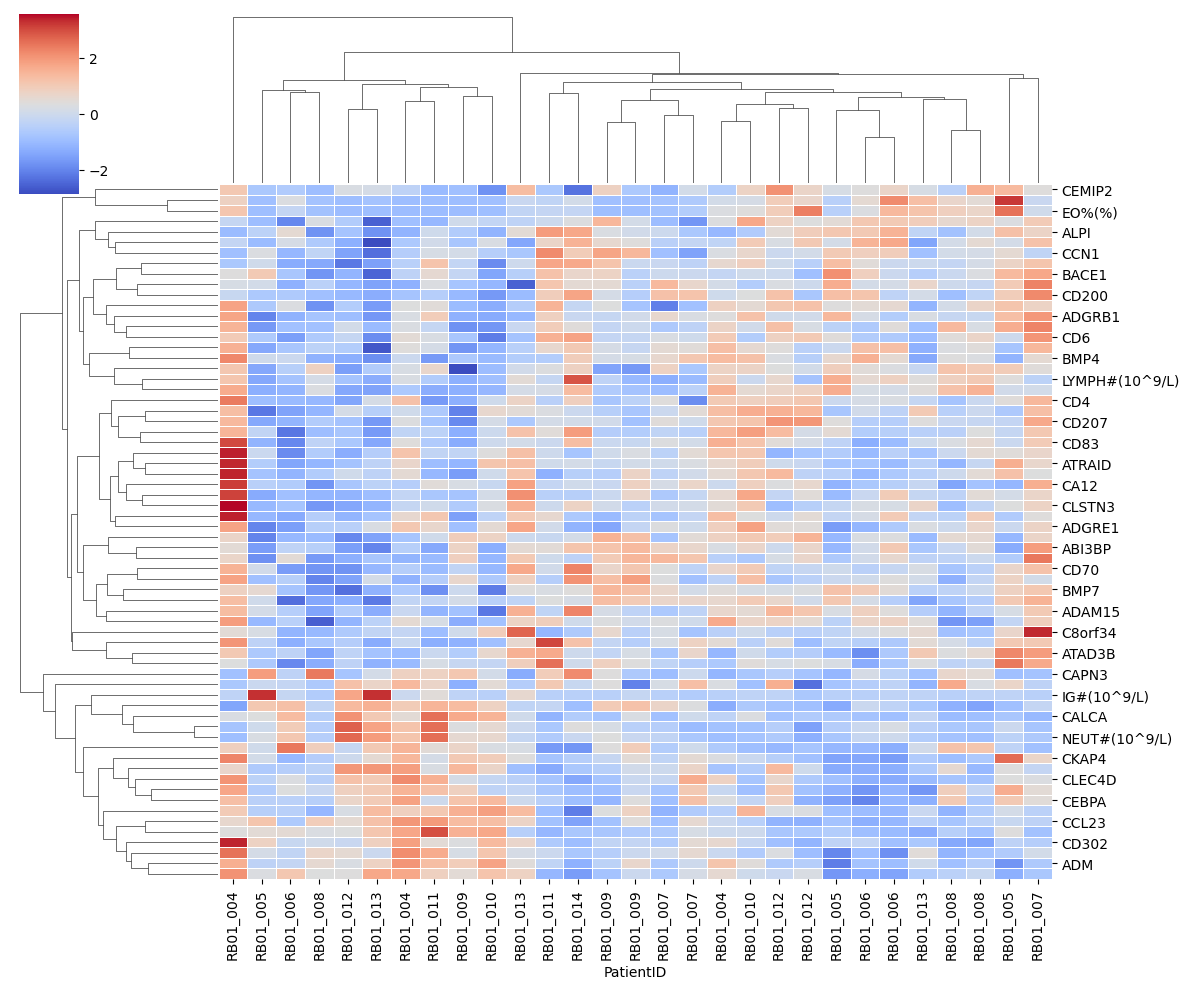

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# ---------------------------
# 1️⃣ Prepare data
# ---------------------------
# Remove unwanted columns (if read from CSV)
df_integrated = df_integrated.loc[:, ~df_integrated.columns.str.contains('^Unnamed')]
df_integrated = df_integrated.reset_index(drop=True)

# Numeric features
numeric_cols = [col for col in df_integrated.columns if col not in ['PatientID','Timepoint']]

# ---------------------------
# 2️⃣ Compute p-values across timepoints (ANOVA)
# ---------------------------
p_values = {}
timepoints = df_integrated['Timepoint'].unique()
for col in numeric_cols:
    groups = [df_integrated[df_integrated['Timepoint']==tp][col].values for tp in timepoints]
    f_stat, p_val = f_oneway(*groups)
    p_values[col] = p_val

p_values = pd.Series(p_values)

# Select significant features (p < 0.05)
sig_features = p_values[p_values < 0.05].index.tolist()
print("Significant features:", sig_features)

# Subset data for clustering
data_cluster = df_integrated[sig_features].copy()

# Scale features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)
data_scaled = pd.DataFrame(data_scaled, columns=sig_features, index=df_integrated['PatientID'])

# ---------------------------
# 3️⃣ PCA (optional, for visualization)
# ---------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca['PatientID'] = df_integrated['PatientID'].values
df_pca['Timepoint'] = df_integrated['Timepoint'].values

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1',
    y='PC2',
    data=df_pca,
    hue='Timepoint',          # color by timepoint
    style='PatientID',        # optional: different shape per patient
    s=100,
    palette='tab10'
)
plt.title("PCA of Significant Features")
plt.show()


# ---------------------------
# 4️⃣ K-means clustering
# ---------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
df_integrated['KMeans_cluster'] = clusters
print("K-means cluster assignment per sample:\n", df_integrated[['PatientID','KMeans_cluster']])

# ---------------------------
# 5️⃣ Hierarchical clustering (dendrogram)
# ---------------------------
linked = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=df_integrated['PatientID'].values, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample")
plt.ylabel("Distance")
plt.show()

# ---------------------------
# 6️⃣ Heatmap with significant features
# ---------------------------
plt.figure(figsize=(12,8))
sns.clustermap(
    data_scaled.T,  # features as rows, samples as columns
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
    linewidths=0.5,
    figsize=(12,10)
)
plt.show()
